<a href="https://colab.research.google.com/github/Voidbubble/bird2vec/blob/master/wavegan_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WaveGAN interactive notebook

This notebook allows you to play with WaveGAN on (free) cloud GPUs.

To get started, go to: `Runtime > Change runtime type > Hardware accelerator > GPU ... Save`

Then, simply run the cells below (`Ctrl + Enter` while highlighting a cell)

In [0]:
# Confirm GPU is running
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
if len(get_available_gpus()) == 0:
  for i in range(4):
    print('WARNING: Not running on a GPU! See above for faster generation')



In [0]:
# CHANGE THIS to use a different dataset
dataset = 'speech' # one of 'digits', 'speech', 'birds', 'drums', 'piano'

# Download model
if dataset == 'digits':
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09_infer.meta -O infer.meta
elif dataset == 'speech':
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit_infer.meta -O infer.meta
elif dataset == 'birds':
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds_infer.meta -O infer.meta
elif dataset == 'drums':
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums_infer.meta -O infer.meta
elif dataset == 'piano':
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano_infer.meta -O infer.meta
else:
  raise NotImplementedError()

In [5]:
# Load the model
import tensorflow as tf

tf.reset_default_graph()
saver = tf.train.import_meta_graph('infer.meta')
graph = tf.get_default_graph()
sess = tf.InteractiveSession()
saver.restore(sess, 'model.ckpt')

INFO:tensorflow:Restoring parameters from model.ckpt


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
# Generate and display audio

# CHANGE THESE to change number of examples generated/displayed
ngenerate = 64
ndisplay = 4

import numpy as np
import PIL.Image
from IPython.display import display, Audio
import time as time

# Sample latent vectors
_z = (np.random.rand(ngenerate, 100) * 2.) - 1.


In [0]:
# Generate
z = graph.get_tensor_by_name('z:0')
G_z = graph.get_tensor_by_name('G_z:0')[:, :, 0]
G_z_spec = graph.get_tensor_by_name('G_z_spec:0')


In [9]:
start = time.time()
_G_z, _G_z_spec = sess.run([G_z, G_z_spec], {z: _z})
print('Finished! (Took {} seconds)'.format(time.time() - start))


Finished! (Took 4.4768595695495605 seconds)


Finished! (Took 0.308871984482 seconds)
--------------------------------------------------------------------------------
Example 0


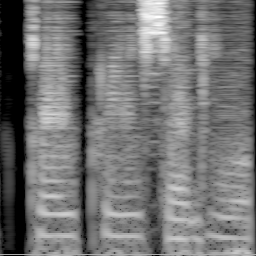

--------------------------------------------------------------------------------
Example 1


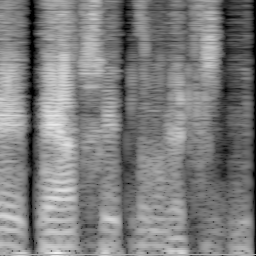

--------------------------------------------------------------------------------
Example 2


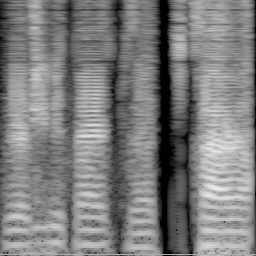

--------------------------------------------------------------------------------
Example 3


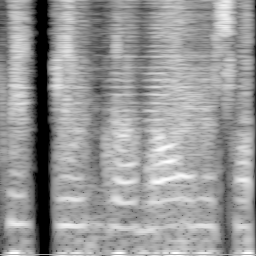

In [0]:
for i in range(ndisplay):
  print('-' * 80)
  print('Example {}'.format(i))
  display(PIL.Image.fromarray(_G_z_spec[i]))
  display(Audio(_G_z[i], rate=16000))

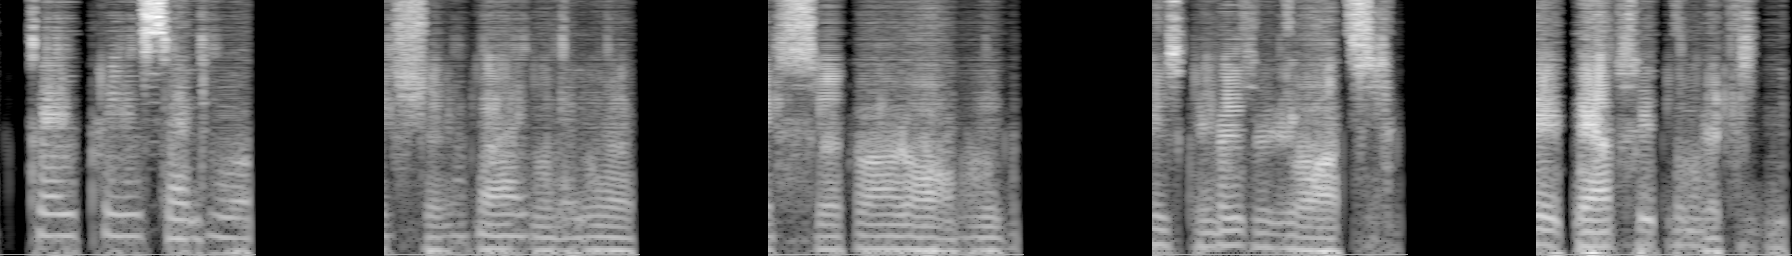

In [0]:
# Interpolate in latent space

# CHANGE THESE to example IDs from the above cell
interp_a = 0
interp_b = 1

# CHANGE THIS to change number of intermediates
interp_n = 3

# Interpolate latent codes
_za, _zb = _z[interp_a], _z[interp_b]
_z_interp = []
for i in range(interp_n + 2):
  a = i / float(interp_n + 1)
  _z_interp.append((1-a) * _za + a * _zb)

# Concatenate for easier visualization
flat_pad = graph.get_tensor_by_name('flat_pad:0')
G_z_flat = graph.get_tensor_by_name('G_z_flat:0')[:, 0]
G_z_spec_padded = tf.pad(G_z_spec, [[0, 0], [0, 0], [0, 128]])
G_z_spec_padded = tf.transpose(G_z_spec_padded, [0, 2, 1])
G_z_spec_flat = tf.reshape(G_z_spec_padded, [-1, 256])
G_z_spec_flat = tf.transpose(G_z_spec_flat, [1, 0])[:, :-128]

# Generate
_G_z_flat, _G_z_spec = sess.run([G_z_flat, G_z_spec_flat], {z: _z_interp, flat_pad: 8192})

# Display
display(PIL.Image.fromarray(_G_z_spec))
display(Audio(_G_z_flat, rate=16000))